# Image Segmentation of Breast Cancer Tumors using U-Net Architecture 

In [1]:
#Install for Grad CAM for visulization Map of the output 
!pip install tf_explain

In [137]:
# Import all libaries 
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import layers
import tensorflow.image as tfi

from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

from keras.metrics import MeanIoU

plt.style.use("ggplot")

# Data Preprocessing 

In [218]:
#Function returns the image at the image path resized to sizexsize pixels, rounded to 4 decimal places and normalized between 0 and 1. 
def load_image(image, size):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(size,size)),4)

#Function returns the images Numy array containing all loaded and processed images. Calls upon the load_image function from above. 
def load_images(image_paths, size, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    if mask:
        images = np.zeros(shape=(len(image_paths), size, size, 1))
    else:
        images = np.zeros(shape=(len(image_paths), size,size, 3))
    for i,image in enumerate(image_paths):
        img = np.round(tfi.resize(img_to_array(load_img(image))/255.,(size,size)),4)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    return images

#Function uses the matplotlib function imshow() to create 2-d numpy array and display the image. 
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

#Function uses the matplotlib function to show originial image with the mask overtop. 
def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [219]:
size=256
root_path = 'Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [220]:
#Sorts and loads the single-mask images into a list. Single mask are indicated by "mask.png" in the file name. 
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
#Sorts and loads the double-mask images into a list. Double mask are indicated by "mask_1.png" in file name. 
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [221]:
#Intialize an empty list to store image and mask paths. For all images with single mask, append the corresponding image and mask into the lists. 
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

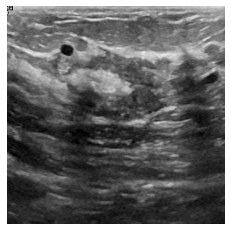

In [222]:
#Exmaple of the image at image_paths index 10. 
show_image(load_image(image_paths[50], size))

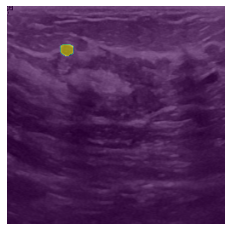

In [223]:
#Example of the image with mask overlay at index 10 (Single mask).
show_mask(load_image(image_paths[50], size), load_image(mask_paths[50], size)[:,:,0], alpha=0.6)

In [224]:
# Combines the mask for images with multiple masks. Array converted to img and saved in location with _mask. 
for class_paths in double_mask_paths:
    for path in class_paths:
        img = np.zeros((1,size,size,3))
        mask1_path=path.replace('mask_1','mask')
        mask1=load_image(mask1_path,size)
        mask2=load_image(path,size)
        img=img+mask1+mask2
        img=img[0,:,:,0]
        img=np.clip(img,0,1)
        img=np.expand_dims(img,axis=-1)
        combined_mask_image=array_to_img(img)
        combined_mask_image.save(mask1_path)
        

In [ ]:
#Exmaple of the image at image_paths[82].
show_image(load_image(image_paths[4], size))

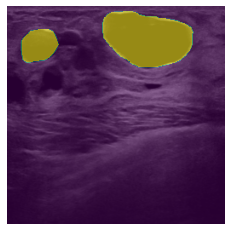

In [226]:
#Example of the image with mask overlay at index 82. (Mutiple masks combined)
show_mask(load_image(image_paths[4], size), load_image(mask_paths[4], size)[:,:,0], alpha=0.6)

In [208]:
#Load images and mask from the list of paths
images = load_images(image_paths, size)
masks = load_images(mask_paths, size, mask=True)

In [209]:
#Function uses matplotlib to plot a grid of images and masks using the show_mask function. 
def plot_img_grid(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(13,8))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        id = np.random.randint(len(images))
        show_mask(images[id], masks[id], cmap='brg')
    plt.tight_layout()
    plt.show()

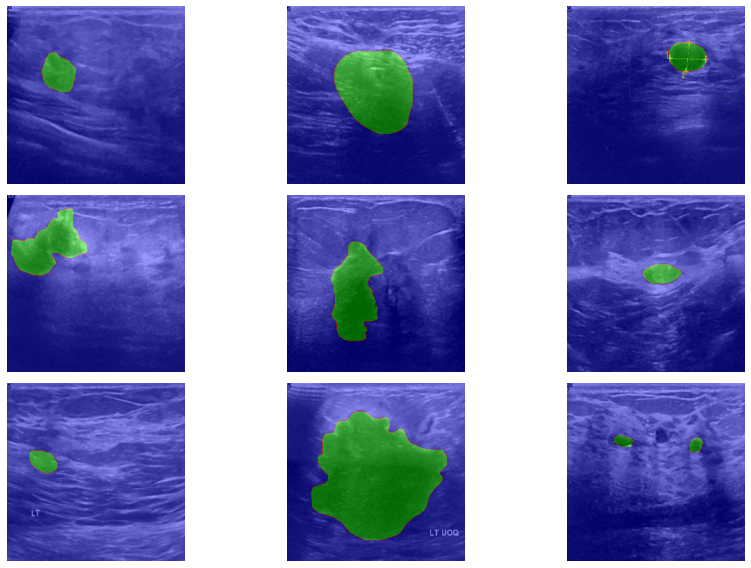

In [210]:
#Exmple of 3x3 grid of images with masks overlay. 
plot_img_grid(3,3 , image_paths, mask_paths )

# U-Net Model 

In [211]:
class EncoderBlock(Layer):
    def __init__(self, filters, kernel_size=3, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same')
        self.act1 = layers.Activation('relu')
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.batch_norm = layers.BatchNormalization()
        self.act2 = layers.Activation('relu')
        self.max_pool = layers.MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.batch_norm(x, training=training)
        x = self.act2(x)
        p = self.max_pool(x)
        return x, p
    
    def get_config(self):
        config = super(EncoderBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
        })
        return config

In [212]:
class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size=3, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.upconv = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')
        self.concat = layers.Concatenate(axis=3)
        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same')
        self.act1 = layers.Activation('relu')
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.batch_norm = layers.BatchNormalization()
        self.act2 = layers.Activation('relu')

    def call(self, inputs, skip_connection, training=False):
        x = self.upconv(inputs)
        x = self.concat([x, skip_connection])
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.batch_norm(x, training=training)
        x = self.act2(x)
        return x
    
    def get_config(self):
        config = super(DecoderBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
        })
        return config

In [ ]:
class ShowProgress(Callback):
    def __init__(self, images, masks, *args, **kwargs):
        super(ShowProgress, self).__init__(*args, **kwargs)
        self.images = images
        self.masks = masks

    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(self.images))
        exp = GradCAM()  
        image = self.images[id]
        mask = self.masks[id]
        pred_mask = self.model.predict(image[np.newaxis, ...])
        cam = exp.explain(
            validation_data=(image[np.newaxis, ...], mask),
            class_index=1,
            model=self.model
        )
        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='brg')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='brg')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder path
encoder1 = EncoderBlock(32,0.1)
encoder2 = EncoderBlock(64,0.1)
encoder3 = EncoderBlock(128,0.2)
encoder4 = EncoderBlock(256,0.2)

s1, p1 = encoder1(input_layer)
s2, p2 = encoder2(p1)
s3, p3 = encoder3(p2)
s4, p4 = encoder4(p3)

# Bottleneck
b1 = EncoderBlock(512)  
b1_output, _ = b1(p4)

# Decoder path
decoder1 = DecoderBlock(256,0.2)
decoder2 = DecoderBlock(128,0.2)
decoder3 = DecoderBlock(64,0.1)
decoder4 = DecoderBlock(32,0.1)

d1 = decoder1(b1_output, s4)
d2 = decoder2(d1, s3)
d3 = decoder3(d2, s2)
d4 = decoder4(d3, s1)

# Output layer
output_layer = layers.Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer], 
    outputs=[output_layer])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress(images=images_val, masks=masks_val)
]

# Data Split 

In [215]:
df = pd.DataFrame(data={'images': image_paths, 'mask': mask_paths })
#Splitting data into train and test with 10% for testing and 90% training. 
df_train, df_test = train_test_split(df, test_size=0.1)

#Splitting training data with 20% alloted to validation.
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(561, 2)
(78, 2)
(141, 2)


In [216]:
#Call the load_images function on training and validation data for both masks and original images. 
images_train= load_images(df_train['images'], size)
masks_train = load_images(df_train['mask'], size, mask=True)
images_val= load_images(df_val['images'], size)
masks_val = load_images(df_val['mask'], size, mask=True)

# Data Training and Validation 

Epoch 1/20
70/70 [==============================] - 825s 12s/step - loss: 0.1872 - accuracy: 0.9338 - IoU: 0.4623 - val_loss: 0.1932 - val_accuracy: 0.9351 - val_IoU: 0.4635


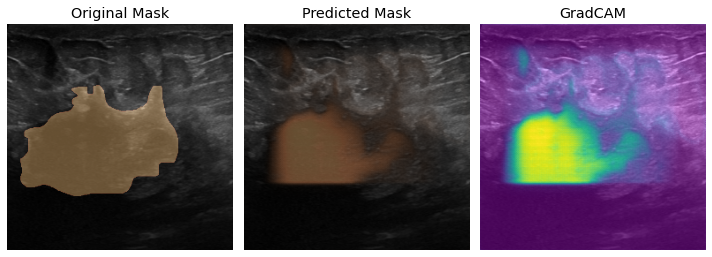

Epoch 2/20
70/70 [==============================] - 800s 12s/step - loss: 0.1781 - accuracy: 0.9369 - IoU: 0.4620 - val_loss: 0.2571 - val_accuracy: 0.9182 - val_IoU: 0.4635


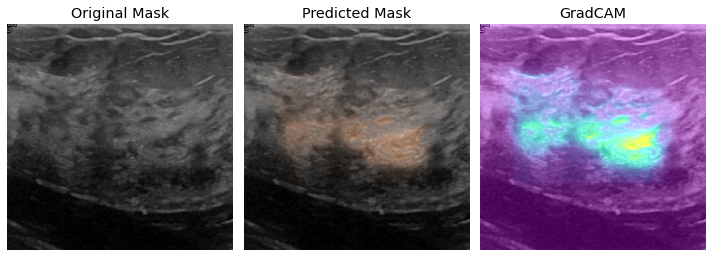

Epoch 3/20
70/70 [==============================] - 858s 12s/step - loss: 0.1682 - accuracy: 0.9410 - IoU: 0.4627 - val_loss: 0.2095 - val_accuracy: 0.9337 - val_IoU: 0.4635


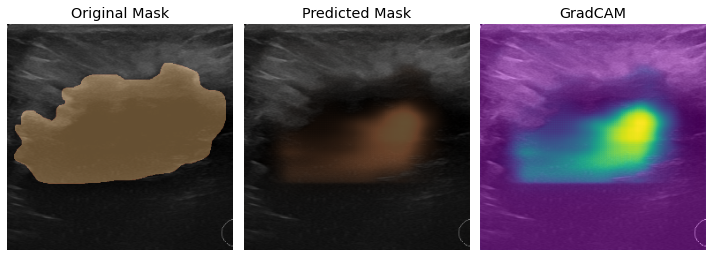

Epoch 4/20
70/70 [==============================] - 840s 12s/step - loss: 0.1749 - accuracy: 0.9377 - IoU: 0.4609 - val_loss: 0.2085 - val_accuracy: 0.9259 - val_IoU: 0.4635


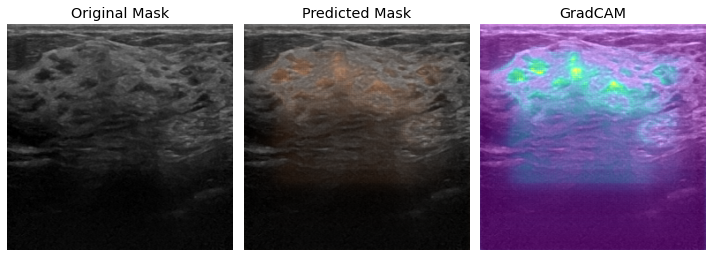

Epoch 5/20
70/70 [==============================] - 789s 11s/step - loss: 0.1569 - accuracy: 0.9449 - IoU: 0.4630 - val_loss: 0.2094 - val_accuracy: 0.9331 - val_IoU: 0.4635


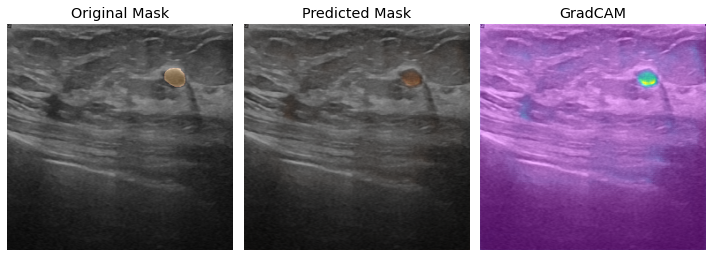

Epoch 6/20
70/70 [==============================] - 768s 11s/step - loss: 0.1584 - accuracy: 0.9443 - IoU: 0.4618 - val_loss: 0.9213 - val_accuracy: 0.7361 - val_IoU: 0.5029


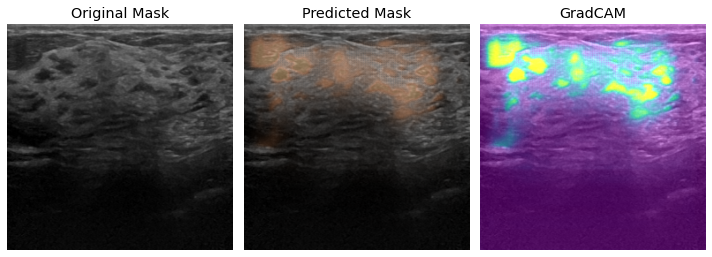

Epoch 7/20
70/70 [==============================] - 757s 11s/step - loss: 0.1543 - accuracy: 0.9461 - IoU: 0.4622 - val_loss: 0.2687 - val_accuracy: 0.8878 - val_IoU: 0.4635


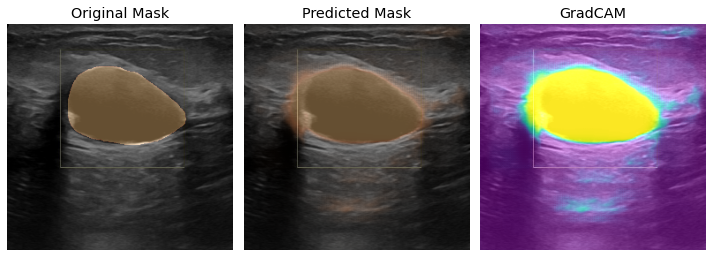

Epoch 8/20
70/70 [==============================] - 842s 12s/step - loss: 0.1456 - accuracy: 0.9475 - IoU: 0.4621 - val_loss: 0.1678 - val_accuracy: 0.9415 - val_IoU: 0.4635


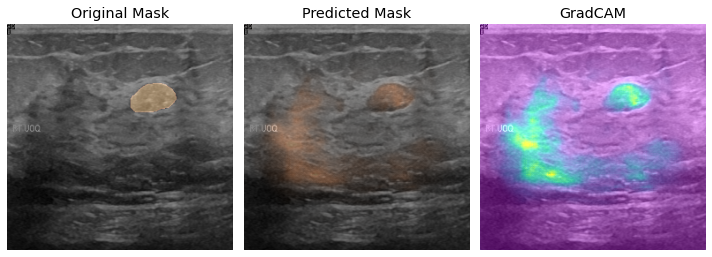

Epoch 9/20
70/70 [==============================] - 805s 12s/step - loss: 0.1497 - accuracy: 0.9481 - IoU: 0.4628 - val_loss: 0.2620 - val_accuracy: 0.9277 - val_IoU: 0.4635


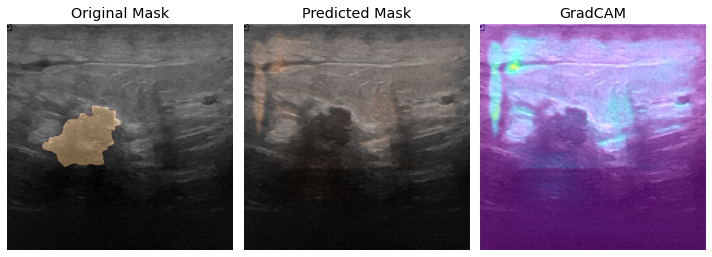

Epoch 10/20
70/70 [==============================] - 751s 11s/step - loss: 0.1548 - accuracy: 0.9446 - IoU: 0.4621 - val_loss: 0.1746 - val_accuracy: 0.9368 - val_IoU: 0.4635


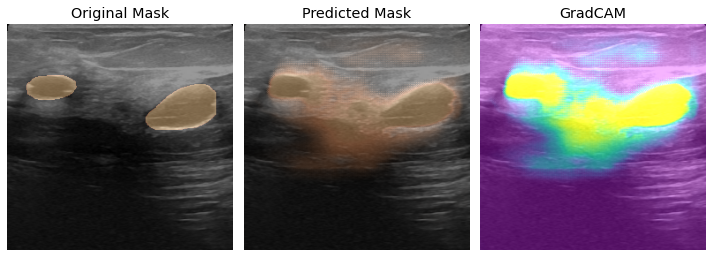

Epoch 11/20
70/70 [==============================] - 869s 12s/step - loss: 0.1433 - accuracy: 0.9485 - IoU: 0.4612 - val_loss: 0.9157 - val_accuracy: 0.6509 - val_IoU: 0.4635


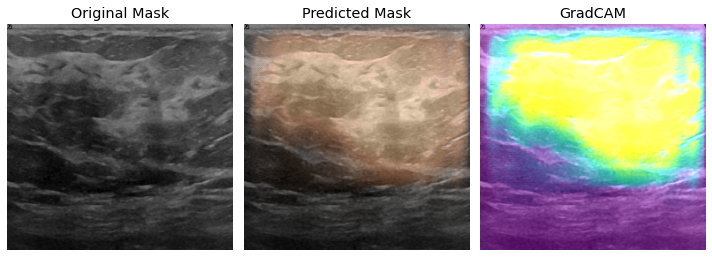

Epoch 12/20
70/70 [==============================] - 771s 11s/step - loss: 0.1411 - accuracy: 0.9508 - IoU: 0.4627 - val_loss: 0.1819 - val_accuracy: 0.9346 - val_IoU: 0.4635


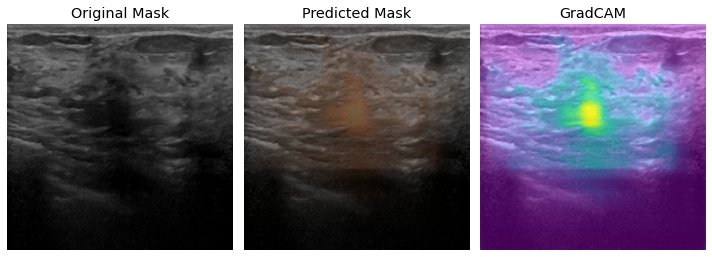

Epoch 13/20
70/70 [==============================] - 832s 12s/step - loss: 0.1435 - accuracy: 0.9492 - IoU: 0.4623 - val_loss: 0.1682 - val_accuracy: 0.9426 - val_IoU: 0.4635


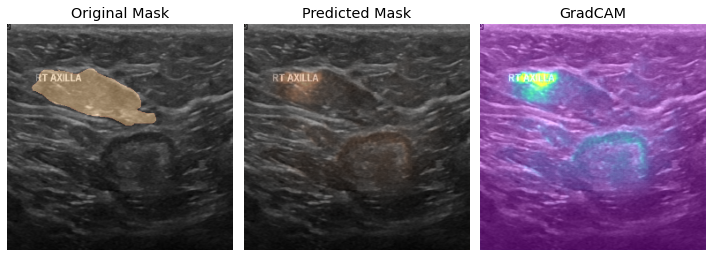

Epoch 14/20
70/70 [==============================] - 852s 12s/step - loss: 0.1320 - accuracy: 0.9528 - IoU: 0.4630 - val_loss: 0.2411 - val_accuracy: 0.9333 - val_IoU: 0.4635


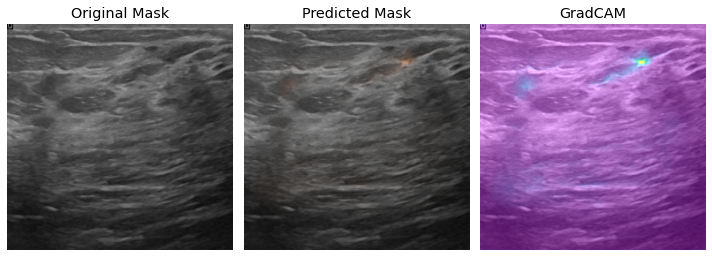

Epoch 15/20
70/70 [==============================] - 823s 12s/step - loss: 0.1286 - accuracy: 0.9540 - IoU: 0.4611 - val_loss: 0.1866 - val_accuracy: 0.9283 - val_IoU: 0.4635


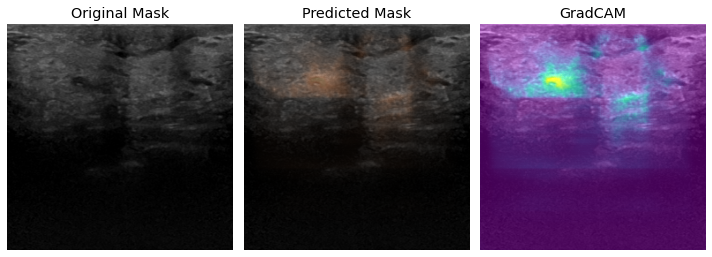

Epoch 16/20
70/70 [==============================] - 809s 12s/step - loss: 0.1300 - accuracy: 0.9533 - IoU: 0.4621 - val_loss: 0.2197 - val_accuracy: 0.9063 - val_IoU: 0.4635


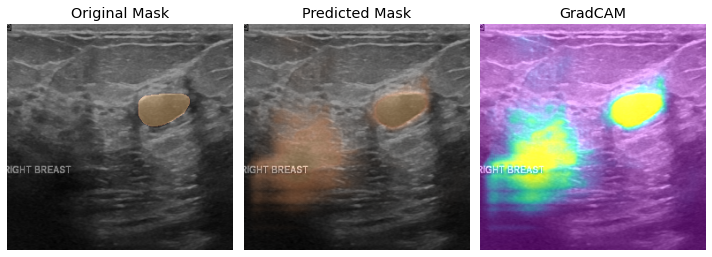

Epoch 17/20
70/70 [==============================] - 915s 13s/step - loss: 0.1275 - accuracy: 0.9549 - IoU: 0.4638 - val_loss: 0.1493 - val_accuracy: 0.9460 - val_IoU: 0.4635


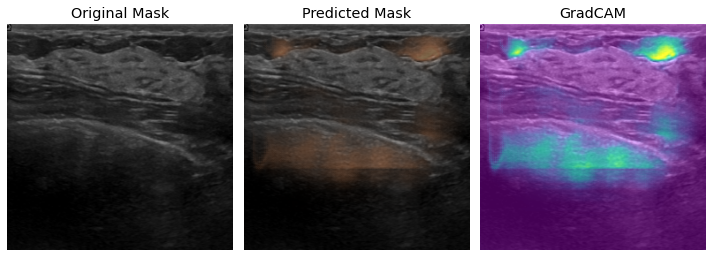

Epoch 18/20
70/70 [==============================] - 931s 13s/step - loss: 0.1274 - accuracy: 0.9549 - IoU: 0.4620 - val_loss: 0.1309 - val_accuracy: 0.9577 - val_IoU: 0.4635


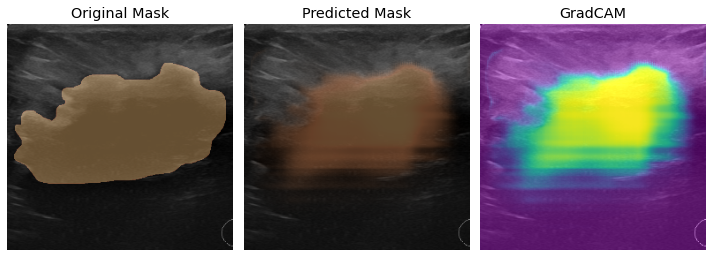

Epoch 19/20
70/70 [==============================] - 780s 11s/step - loss: 0.1202 - accuracy: 0.9563 - IoU: 0.4620 - val_loss: 0.1451 - val_accuracy: 0.9500 - val_IoU: 0.4635


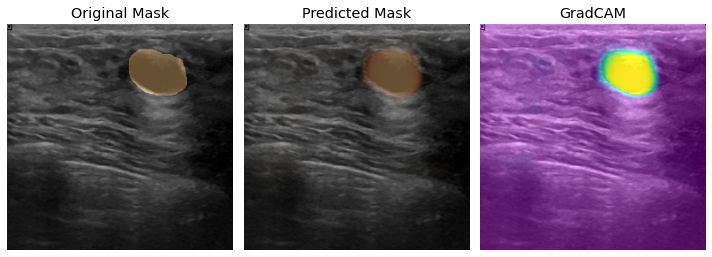

Epoch 20/20
70/70 [==============================] - 739s 11s/step - loss: 0.1313 - accuracy: 0.9526 - IoU: 0.4622 - val_loss: 0.1949 - val_accuracy: 0.9356 - val_IoU: 0.4635


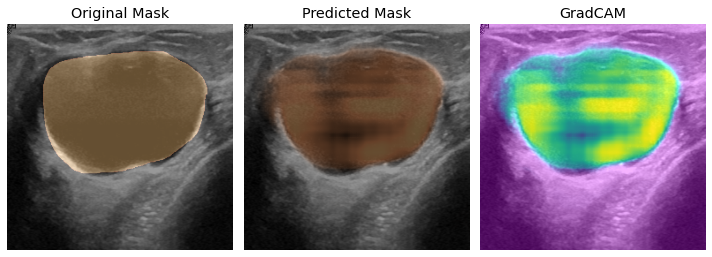

In [234]:
#Training  the model using the model.fit function based on specified conditions. 
BATCH_SIZE=8 #Update weight after 8 images
EPOCHS=20 #Pass training dataset 20 times through model 
results = model.fit(
    images_train, masks_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    steps_per_epoch=len(images_train)//BATCH_SIZE,
    callbacks=cb,
    validation_data= (images_val, masks_val),
    validation_steps=len(images_val)//BATCH_SIZE
)

# Performance Metrics

In [238]:
#Pulling evaluation metrics from the training stage. The plots below show the comparsion between training and validation data. 
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()


In [245]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.ylabel("IoU")
plt.xlabel("Epochs")
plt.grid()

plt.show()

KeyboardInterrupt: 

# Testing 

In [240]:
#Call the load_images function on testing data for both masks and original images.
images_test= load_images(df_test['images'], size)
masks_test = load_images(df_test['mask'], size, mask=True)

In [241]:
# Running metrics on the trained model using the test data. 
results = model.evaluate(images_test,masks_test, steps=len(images_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test Accuracy ', results[1] )
print('Test IOU', results[2] )

9/9 [==============================] - 19s 2s/step - loss: 0.2423 - accuracy: 0.9163 - IoU: 0.4544
Test Loss  0.24234718084335327
Test Accuracy  0.9162699580192566
Test IOU 0.45438024401664734


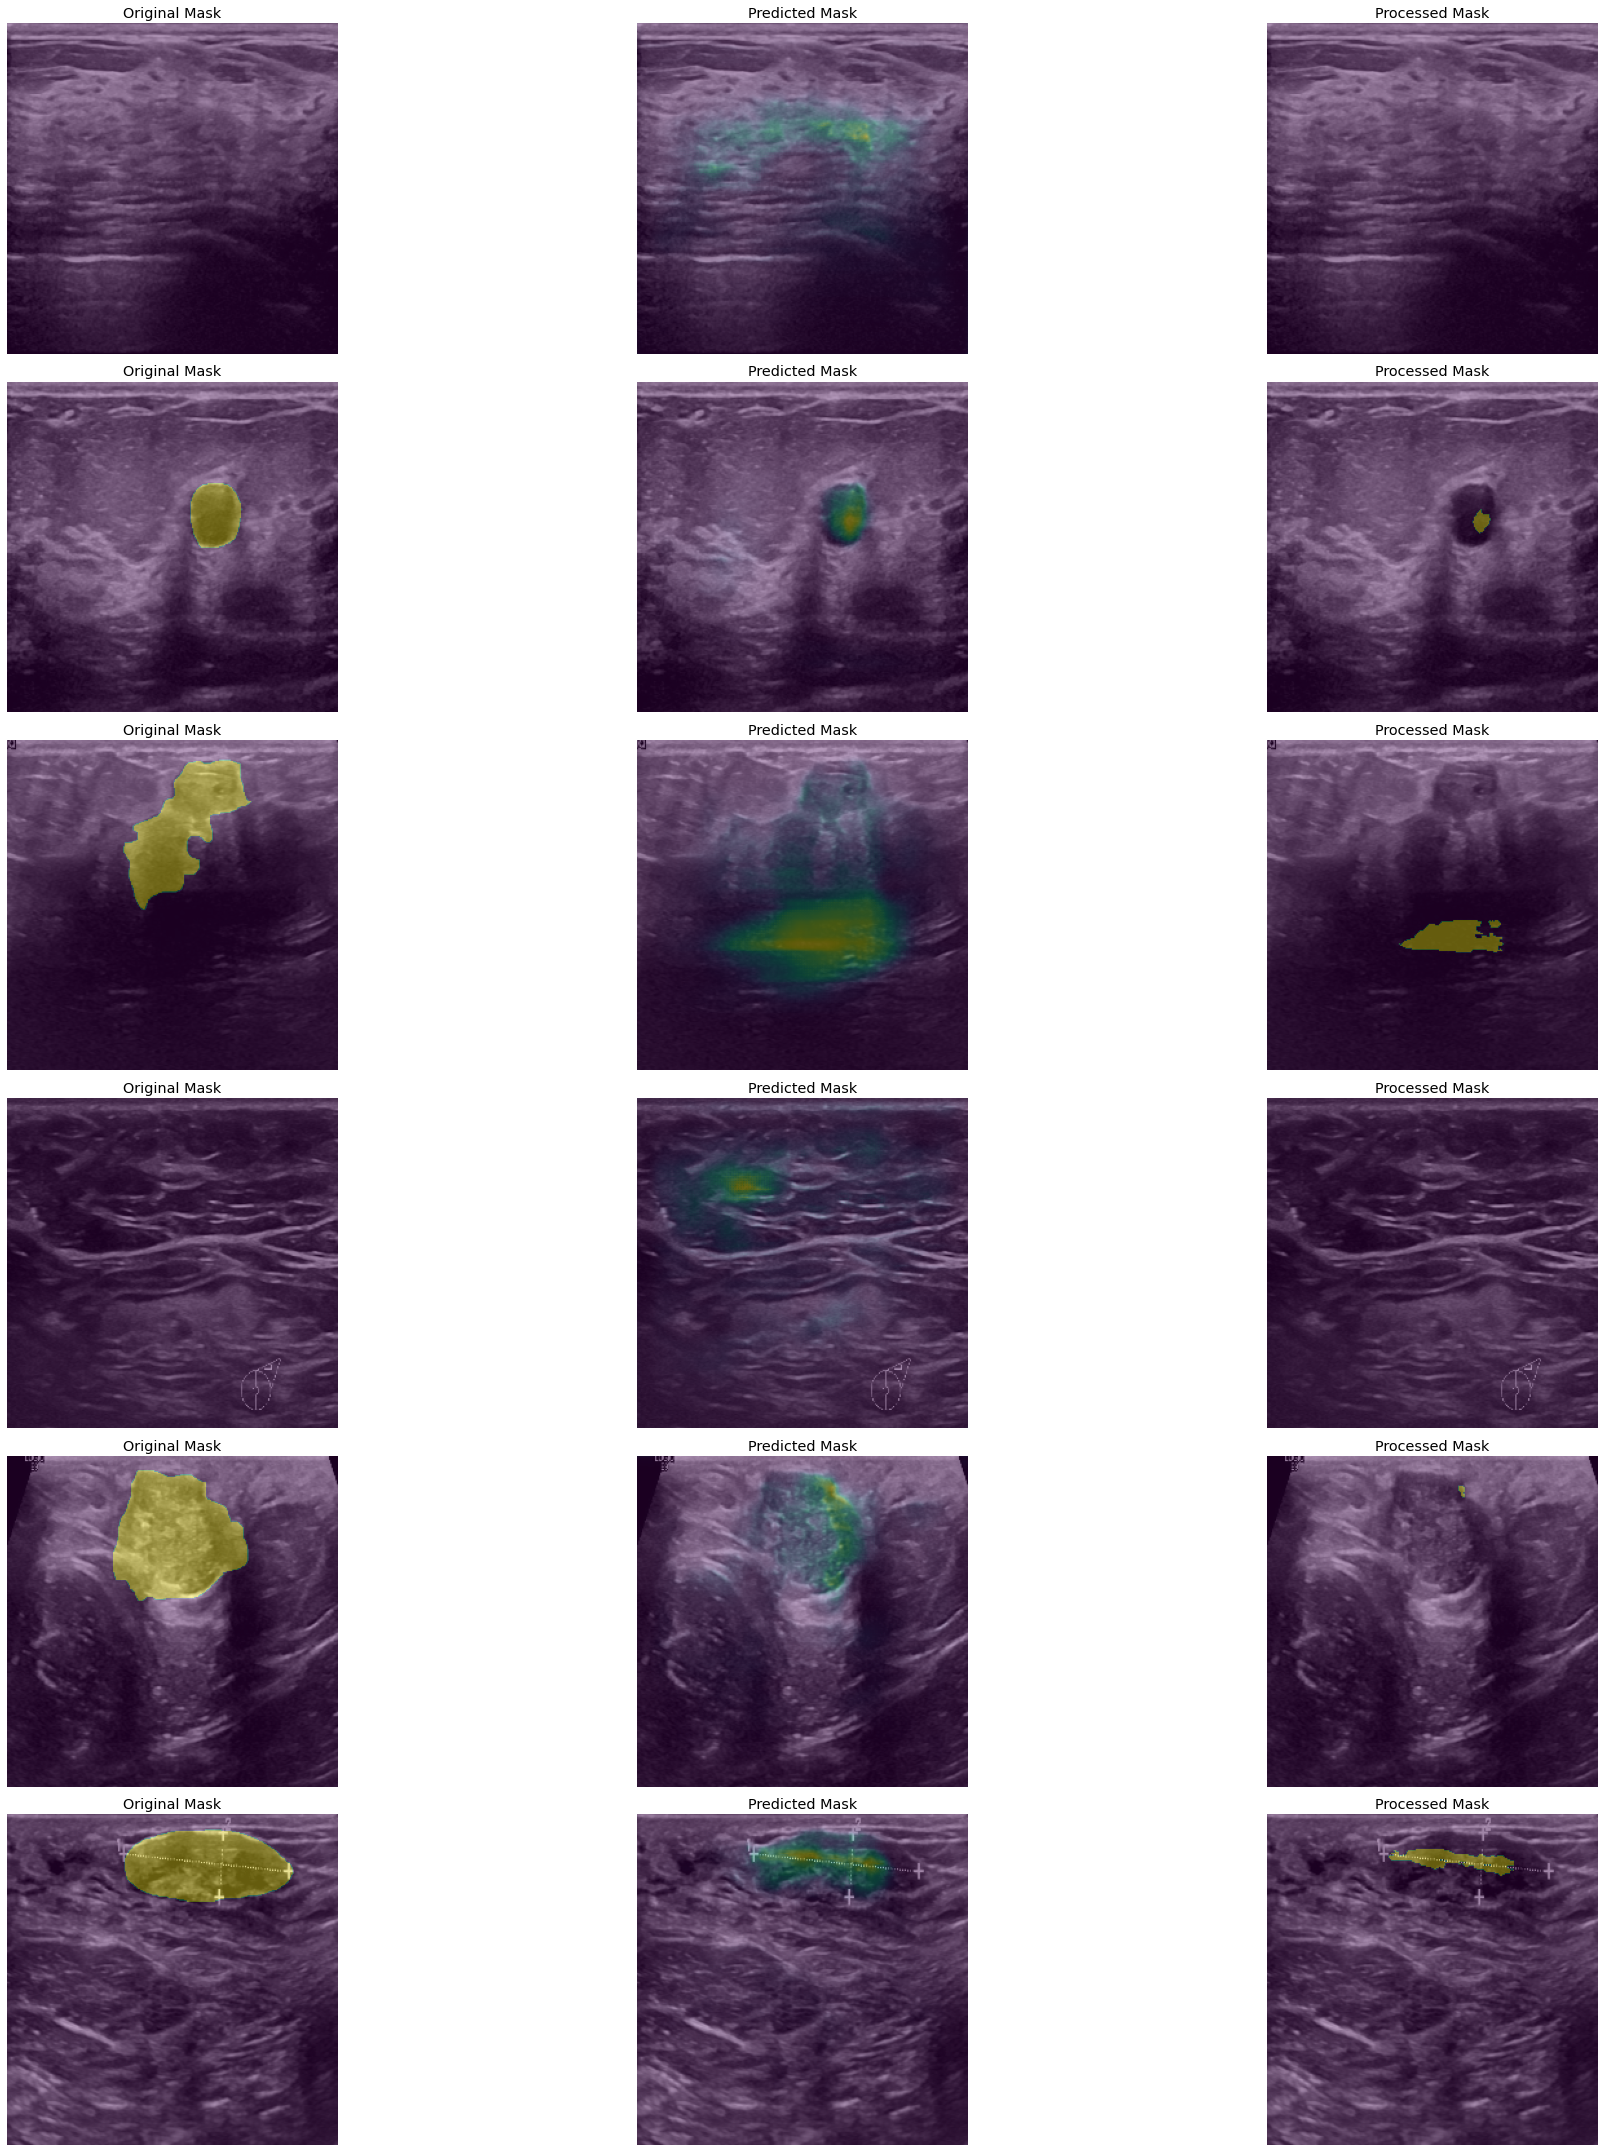

In [243]:
#Display final results from testing data. Only showed 6 randomly by calling a random ID. 
#Original, Predicted and Processed Mask is displayed. 

plt.figure(figsize=(30,30))
n=0
test_len=len(images_test)

for i in range(1,(6*3+1)):
    plt.subplot(6,3,i)
    if n==0:
        id=np.random.randint(test_len)
        image = images_test[id]
        mask = masks_test[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()